# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 3: Neural Machine Translation (30 pts)
In this part, you implement Transformer encoder for Neural Machine Translation (NMT) using a sequence to sequence (seq2seq) model for English to French translation with PyTorch.

---
### 1 Transformer Encoder (18 pts)

In [1]:
# Import required packages
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
# from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import time
from tqdm import notebook
from functools import partial
import math

In [2]:
# Add utilities path
import sys

path_to_utils = 'pyfiles'
sys.path.append(path_to_utils)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/My Drive/NLP

Mounted at /content/drive/
/content/drive/My Drive/NLP


In [4]:
# Import custom modules
import global_variables
import nmt_dataset
import nnet_models_new

In [5]:
# Load data
import os

source_name = 'en'
target_name = 'fr'

base_saved_models_dir = '.'
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

main_data_path = './data/'

path_to_train_data = {'source':main_data_path+'train.'+source_name, 
                      'target':main_data_path+'train.'+target_name}
path_to_val_data = {'source': main_data_path+'valid.'+source_name, 
                      'target':main_data_path+'valid.'+target_name}

In [6]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

In [7]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999))
batchSize = 64

In [8]:
from functools import partial
from torch.utils.data import DataLoader

dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

In [9]:
# Configuration
source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words;
target_vocab = dataset_dict['train'].target_lang_obj.n_words;
hidden_size = 512
enc_layers = 1
lr = 0.01;
longest_label = 1;
gradient_clip = 0.3;
use_cuda = True
dropout = 0.5
n_head = 2

num_epochs = 20

#### 1.1 Encoder (9 pts)

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [11]:
# Add transformer as encoder in seq2seq model

# code below can help you to start it, but feel free to start from scratch

class EncoderTransformer(nn.Module):
  def __init__(self,source_vocab,hidden_size,dropout,n_heads):
    super().__init__()
    
    # you need to add more things here
    self.embedding = nn.Embedding(source_vocab,hidden_size)
    self.position_embed = PositionalEncoding(hidden_size, dropout) # sinusoidal embedding
    encoder_layer = nn.TransformerEncoderLayer(hidden_size,n_heads)
    self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

  def forward(self, text_vec):
    # some helpful directions below, check the MLM lab for more details
    embedded = self.embedding(text_vec)
    pos_embedded = self.position_embed(embedded)

    # embedded = pos_embedded + embedded  # apply pos embedding
    output = self.transformer(embedded)
    hidden = output.mean(1,True)
    hidden = hidden.transpose(0,1)
    
    return output,hidden
        

In [12]:
encoder_rnn = EncoderTransformer(target_vocab,hidden_size,dropout,n_head)

#### 1.2 Decoder(s) (9 pts)

In [13]:
# Basic RNN decoder (no attention)
decoder_rnn = nnet_models_new.DecoderRNN(target_vocab, hidden_size,1)

In [14]:
# RNN Decoder with Encoder attention
decoder_rnn_attn = nnet_models_new.Decoder_SelfAttn(target_vocab,hidden_size, dropout, self_attention = False, encoder_attention = True)

In [15]:
# RNN Decoder with Encoder & Self attention
decoder_rnn_self_attn = nnet_models_new.Decoder_SelfAttn(target_vocab,hidden_size, dropout, self_attention = True, encoder_attention = True)

#### Training & Evaluation

In [16]:
nmt_rnn = nnet_models_new.seq2seq(encoder_rnn, decoder_rnn,
                              lr = 0.25, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [17]:
def save_models(nmt_model, path, enc_type,train_loss,validation_bleu):
    if not os.path.exists(path):
            os.makedirs(path)
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    torch.save(nmt_model, os.path.join(path, filename))
    torch.save({'train_loss':train_loss,'validation_bleu':validation_bleu},os.path.join(path, filename+'loss'))

In [ ]:
# Train
def train_model(dataloader, nmt, num_epochs=50, val_every=1, saved_model_path = '.', enc_type ='rnn'):
    
    train_losses = []
    validation_bleu = []
    best_bleu = -1;
    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch, num_epochs));
        
        for i, data in notebook.tqdm(enumerate(dataloader['train']), total=len(dataloader['train'])):  
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader['train']) 
        
        print("epoch {} loss = {}, time = {}".format(epoch, epoch_loss,
                                                        time.time() - start))
        train_losses.append(epoch_loss)
        sys.stdout.flush()
        
        if epoch%val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            print('validation bleu: ', val_bleu_score)
            validation_bleu.append(val_bleu_score)
            sys.stdout.flush()
            
            nmt.scheduler_step(val_bleu_score);
            
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                save_models(nmt, saved_model_path, enc_type,train_losses,validation_bleu);

        print('='*50)

    print("Training completed. Best BLEU is {}".format(best_bleu))
    return train_losses,validation_bleu

In [ ]:
train_loss_basic_encoder,validation_bleu_basic_encoder = train_model(dataloader_dict, nmt_rnn, 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      enc_type = 'rnn_basic')

Epoch: [0/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 0 loss = 1.771868376520532, time = 234.17713141441345
validation bleu:  5.907061380859886
Epoch: [1/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 1 loss = 1.4838438993675886, time = 233.58544182777405
validation bleu:  5.382734884403561
Epoch 00002: reducing learning rate of group 0 to 2.5000e-02.
Epoch: [2/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 2 loss = 1.1611801022307695, time = 236.13608407974243
validation bleu:  10.623867404058254
Epoch: [3/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 3 loss = 1.0460378040567329, time = 246.09859037399292
validation bleu:  12.440636575268277
Epoch: [4/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 4 loss = 0.9719920925156231, time = 235.03744101524353
validation bleu:  14.361306733046554
Epoch: [5/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 5 loss = 0.9031876017017048, time = 235.96006560325623
validation bleu:  16.328617892751478
Epoch: [6/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 6 loss = 0.8469688335779301, time = 234.8732180595398
validation bleu:  17.552220082011313
Epoch: [7/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 7 loss = 0.7947416101961585, time = 234.48604249954224
validation bleu:  18.704054594849108
Epoch: [8/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 8 loss = 0.7480606831837229, time = 233.77517223358154
validation bleu:  19.69447366866462
Epoch: [9/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 9 loss = 0.7080864613901545, time = 233.6190369129181
validation bleu:  20.545993099249426
Epoch: [10/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 10 loss = 0.6721639944245611, time = 231.73572182655334
validation bleu:  20.943913207872715
Epoch: [11/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 11 loss = 0.6394110741377538, time = 232.85189008712769
validation bleu:  21.769829119251018
Epoch: [12/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 12 loss = 0.6098231596794815, time = 232.4440734386444
validation bleu:  22.26950501752151
Epoch: [13/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 13 loss = 0.5820755703462458, time = 235.38995122909546
validation bleu:  22.909970050912253
Epoch: [14/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 14 loss = 0.5595940634484436, time = 236.71594548225403
validation bleu:  22.911881695892475
Epoch 00015: reducing learning rate of group 0 to 2.5000e-03.
Epoch: [15/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 15 loss = 0.49840654141354757, time = 237.2057695388794
validation bleu:  24.878191541716404
Epoch: [16/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 16 loss = 0.48452282711409467, time = 238.0300042629242
validation bleu:  25.156319332420562
Epoch: [17/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 17 loss = 0.48018663051716176, time = 238.70655608177185
validation bleu:  25.203769609023936
Epoch: [18/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 18 loss = 0.4752791269829399, time = 239.70439839363098
validation bleu:  25.49158267056495
Epoch: [19/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 19 loss = 0.4731831550763254, time = 236.77943587303162
validation bleu:  25.450135896618903
Epoch 00020: reducing learning rate of group 0 to 2.5000e-04.
Training completed. Best BLEU is 25.49158267056495


In [ ]:
# Don't forget to remove
path = saved_models_dir
filename = 'nmt_enc_rnn_basic_dec_rnn.pth'
dictey = torch.load(os.path.join(path, filename+'loss'))
train_loss_basic_encoder,validation_bleu_basic_encoder = dictey['train_loss'],dictey['validation_bleu']

In [18]:
import matplotlib.pyplot as plt
def plot_curves(training_loss,validation_bleu,epochs):
  epoch_list = list(range(epochs))
  plt.subplot(1,2,1)
  plt.title('Training Epochs vs Training Loss')
  plt.plot(epoch_list, training_loss, 'b')
  plt.ylabel('Training Loss')
  plt.xlabel('Number of Epochs')
  plt.subplot(1,2,2)
  plt.title('Validation Epochs vs Validation Bleu')
  plt.plot(epoch_list, validation_bleu, 'r')
  plt.ylabel('Validation Bleu')
  plt.xlabel('Number of Epochs')

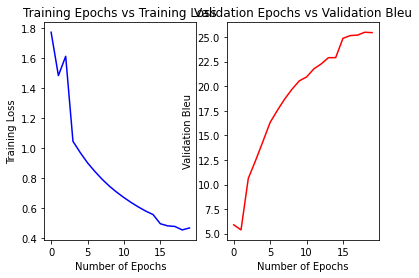

In [ ]:
plot_curves(train_loss_basic_encoder,validation_bleu_basic_encoder,20)

In [19]:
nmt_rnn_encoder_attn = nnet_models_new.seq2seq(encoder_rnn, decoder_rnn_attn,
                              lr = 0.01, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [ ]:
train_loss_encoder_attn,validation_bleu_basic_encoder_attn = train_model(dataloader_dict, nmt_rnn_encoder_attn, 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      enc_type = 'rnn_encoder_attn')

Epoch: [0/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 0 loss = 2.3742456402474823, time = 421.09452533721924
validation bleu:  2.0101950038979277
Epoch: [1/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 1 loss = 1.7480394898359135, time = 435.43454694747925
validation bleu:  3.8992584082362276
Epoch: [2/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 2 loss = 1.5467565591975923, time = 443.7127809524536
validation bleu:  6.491772113727536
Epoch: [3/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 3 loss = 1.4154245299315518, time = 437.81526017189026
validation bleu:  7.572895872257939
Epoch: [4/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 4 loss = 1.3049570617253101, time = 442.9926471710205
validation bleu:  9.5773240708621
Epoch: [5/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 5 loss = 1.2093317509357948, time = 444.74977684020996
validation bleu:  11.652532820370784
Epoch: [6/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 6 loss = 1.1395395560938235, time = 444.91779088974
validation bleu:  12.837261548094538
Epoch: [7/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 7 loss = 1.0703006543611224, time = 439.1708171367645
validation bleu:  14.547396065334667
Epoch: [8/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 8 loss = 1.0135087974513997, time = 435.29314064979553
validation bleu:  15.983745702924493
Epoch: [9/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 9 loss = 0.9598339566893855, time = 436.32947063446045
validation bleu:  17.052146455838383
Epoch: [10/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 10 loss = 0.9133959518245053, time = 433.70976090431213
validation bleu:  18.18039718107338
Epoch: [11/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 11 loss = 0.8714531302947417, time = 436.77261447906494
validation bleu:  20.22060380602665
Epoch: [12/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 12 loss = 0.8345730040212087, time = 434.50304341316223
validation bleu:  20.91967904299823
Epoch: [13/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 13 loss = 0.8013853073615447, time = 435.349675655365
validation bleu:  21.645503017080316
Epoch: [14/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 14 loss = 0.7701436323967666, time = 432.80270171165466
validation bleu:  21.832132405338626
Epoch: [15/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 15 loss = 0.7395991746903787, time = 431.2519805431366
validation bleu:  22.87556484247047
Epoch: [16/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 16 loss = 0.7123690048743483, time = 432.60364174842834
validation bleu:  24.165940990067735
Epoch: [17/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 17 loss = 0.6894703886350436, time = 410.9903202056885
validation bleu:  23.97980609026282
Epoch 00018: reducing learning rate of group 0 to 1.0000e-03.
Epoch: [18/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 18 loss = 0.6303477615365691, time = 407.52548456192017
validation bleu:  25.983820984023655
Epoch: [19/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 19 loss = 0.61224645318417, time = 422.8823299407959
validation bleu:  26.585054614066657
Training completed. Best BLEU is 26.585054614066657


In [ ]:
# Don't forget to remove
path = saved_models_dir
filename = 'nmt_enc_rnn_encoder_attn_dec_rnn.pth'
dictey = torch.load(os.path.join(path, filename+'loss'))
train_loss_encoder_attn,validation_bleu_basic_encoder_attn = dictey['train_loss'],dictey['validation_bleu']

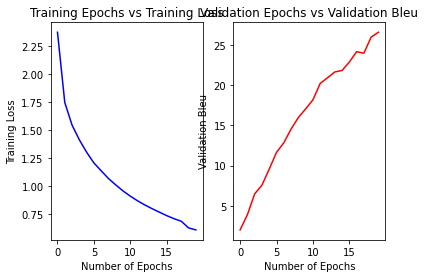

In [ ]:
plot_curves(train_loss_encoder_attn,validation_bleu_basic_encoder_attn,20)

In [ ]:
filename = 'nmt_enc_rnn_encoder_attn_dec_rnn.pth'
trained_model_loss = torch.load(os.path.join(saved_models_dir, filename))

In [20]:
nmt_rnn_encoder_self_attn = nnet_models_new.seq2seq(encoder_rnn, decoder_rnn_self_attn,
                              lr = 0.01, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [ ]:
train_loss_encoder_self_attn,validation_bleu_encoder_self_attn = train_model(dataloader_dict, nmt_rnn_encoder_self_attn, 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      enc_type = 'rnn_encoder_self_attn')

Epoch: [0/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 0 loss = 2.2992321438406313, time = 417.5335884094238
validation bleu:  4.678960514291286
Epoch: [1/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 1 loss = 1.6700305170960044, time = 427.81817865371704
validation bleu:  8.53836900324019
Epoch: [2/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 2 loss = 1.4899656354225244, time = 427.71707677841187
validation bleu:  10.847738977616626
Epoch: [3/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 3 loss = 1.364149532093566, time = 426.7153069972992
validation bleu:  14.107560233601712
Epoch: [4/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 4 loss = 1.26573287661386, time = 428.0271785259247
validation bleu:  15.856136402634748
Epoch: [5/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 5 loss = 1.1887172647460347, time = 430.16863989830017
validation bleu:  17.45110607466266
Epoch: [6/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 6 loss = 1.1307912270448215, time = 428.1989998817444
validation bleu:  18.334002050991934
Epoch: [7/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 7 loss = 1.0870701335473734, time = 428.05207872390747
validation bleu:  18.448613560626832
Epoch: [8/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 8 loss = 1.04617841514524, time = 427.97237944602966
validation bleu:  20.014202794066172
Epoch: [9/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 9 loss = 1.0107782980411666, time = 427.67149448394775
validation bleu:  20.20893030841041
Epoch: [10/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 10 loss = 0.9824395898306468, time = 428.2225716114044
validation bleu:  21.481421967980264
Epoch: [11/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 11 loss = 0.9521716054126497, time = 428.2236816883087
validation bleu:  21.18947412860017
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Epoch: [12/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 12 loss = 0.8978844202291272, time = 427.88355708122253
validation bleu:  23.39387032831771
Epoch: [13/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 13 loss = 0.8730177475309768, time = 429.2671639919281
validation bleu:  24.422265945852324
Epoch: [14/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 14 loss = 0.8553052172106058, time = 428.4739487171173
validation bleu:  24.789783434247724
Epoch: [15/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 15 loss = 0.8444797569034502, time = 427.75991201400757
validation bleu:  25.173587810261218
Epoch: [16/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 16 loss = 0.8378643291643783, time = 427.0746018886566
validation bleu:  25.27936947026185
Epoch: [17/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 17 loss = 0.8262958134640617, time = 428.3453109264374
validation bleu:  25.748730975427616
Epoch: [18/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 18 loss = 0.8223000429508759, time = 427.9921803474426
validation bleu:  25.584634255600037
Epoch 00019: reducing learning rate of group 0 to 1.0000e-04.
Epoch: [19/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 19 loss = 0.8163696403978934, time = 426.99588418006897
validation bleu:  25.748367764198445
Training completed. Best BLEU is 25.748730975427616


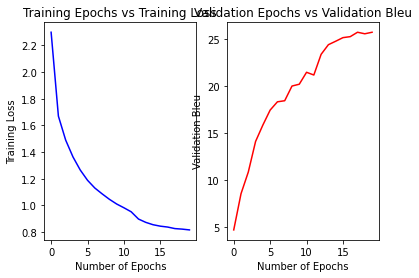

In [ ]:
plot_curves(train_loss_encoder_self_attn,validation_bleu_encoder_self_attn,20)

---
### 2 Attention visualization (12 pts)

In [ ]:
# Model was trained in ~2 hours, i.e. you can expect attention maps
# to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

In [45]:
filename = 'nmt_enc_rnn_basic_dec_rnn.pth'
nmt = torch.load(os.path.join(saved_models_dir,filename))

In [21]:
filename = 'nmt_enc_rnn_encoder_attn_dec_rnn.pth'
nmt_encoder_attn = torch.load(os.path.join(saved_models_dir,filename))

In [22]:
filename = 'nmt_enc_rnn_encoder_self_attn_dec_rnn.pth'
nmt_encoder_self_attn = torch.load(os.path.join(saved_models_dir,filename))

In [53]:
import copy
import numpy as np
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
    
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [global_variables.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ')+
                       [global_variables.EOS_TOKEN]);

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def get_encoded_batch(sentence, lang_obj, use_cuda):
    """ accepts only bsz = 1.
        input: one sentence as a string
        output: named tuple with vector and length"""
    
    sentence = sentence + ' ' + global_variables.EOS_TOKEN;
    tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)
    
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
    
    named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
    return_tuple = named_returntuple( tensor.to(device), 
                                     torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
                                     None,
                                     None,
                                     False );

    return return_tuple

def get_translation(nmt_model, sentence, lang_obj, use_cuda):
    print('souce: ', sentence)
    batch = get_encoded_batch(sentence, lang_obj, use_cuda);
    prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn = True);
    prediction = prediction[0];
    print('prediction: ', prediction)
    
    if attn_scores_list[0] is not None:
        if attn_scores_list[0][0] is not None:
            attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list];
            attn_matrix = np.stack(attn_matrix)[:,:, 0]
            showAttention(sentence, prediction, attn_matrix)

In [54]:
val_samples = dataset_dict['val'].main_df.sample(3)

In [55]:
source_list = list(val_samples['source_data'])
target_list = list(val_samples['target_data'])

First Example
Decoder with no Attention
souce:  i m not safe in here .
prediction:  ne sois pas ici en securite ici .
Actual Translation is je ne suis pas en securite la dedans .
------------------------------------------------
Decoder with Encoder Attention
souce:  i m not safe in here .
prediction:  ne pas rester ici en securite .


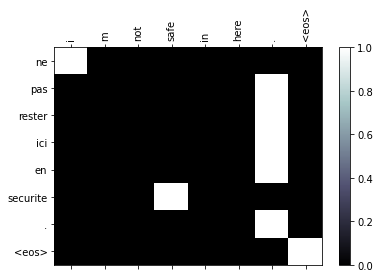

Actual Translation is je ne suis pas en securite la dedans .
------------------------------------------------
Decoder with Encoder Attention
souce:  i m not safe in here .
prediction:  je ne suis pas en securite ici .


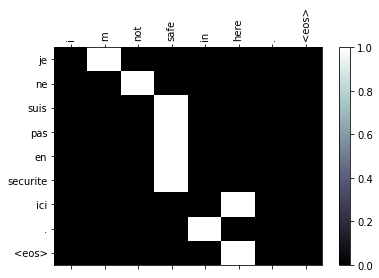

Actual Translation is je ne suis pas en securite la dedans .


In [56]:
print ("First Example")
print ("Decoder with no Attention")
get_translation(nmt, source_list[0], source_lang_obj, use_cuda)
print ("Actual Translation is "+target_list[0])

print ("------------------------------------------------")

print ("Decoder with Encoder Attention")
get_translation(nmt_encoder_attn, source_list[0], source_lang_obj, use_cuda)
print ("Actual Translation is "+target_list[0])

print ("------------------------------------------------")

print ("Decoder with Encoder Attention")
get_translation(nmt_encoder_self_attn, source_list[0], source_lang_obj, use_cuda)
print ("Actual Translation is "+target_list[0])

Second Example
Decoder with no Attention
souce:  i like all of the songs that tom sings .
prediction:  tous les enfants aiment de la musique .
Actual Translation is j aime toutes les chansons que tom chante .
------------------------------------------------
Decoder with Encoder Attention
souce:  i like all of the songs that tom sings .
prediction:  tom aime les chansons de tout .


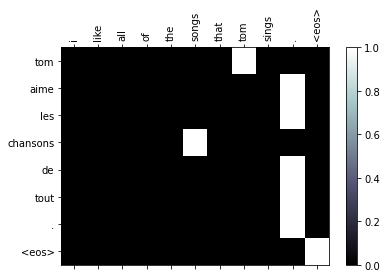

Actual Translation is j aime toutes les chansons que tom chante .
------------------------------------------------
Decoder with Encoder Attention
souce:  i like all of the songs that tom sings .
prediction:  tom a apprecie tout ce qu il s est fait .


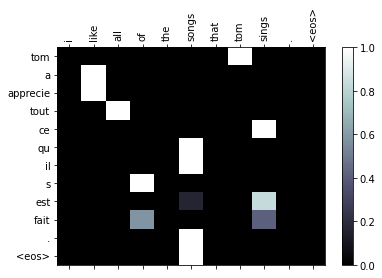

Actual Translation is j aime toutes les chansons que tom chante .


In [57]:
print ("Second Example")
print ("Decoder with no Attention")
get_translation(nmt, source_list[1], source_lang_obj, use_cuda)
print ("Actual Translation is "+target_list[1])

print ("------------------------------------------------")

print ("Decoder with Encoder Attention")
get_translation(nmt_encoder_attn, source_list[1], source_lang_obj, use_cuda)
print ("Actual Translation is "+target_list[1])

print ("------------------------------------------------")

print ("Decoder with Encoder Attention")
get_translation(nmt_encoder_self_attn, source_list[1], source_lang_obj, use_cuda)
print ("Actual Translation is "+target_list[1])

Third Example
Decoder with no Attention
souce:  you don t even know who they are .
prediction:  elles ne sont meme pas meme .
Actual Translation is vous ne savez meme pas qui ils sont .
------------------------------------------------
Decoder with Encoder Attention
souce:  you don t even know who they are .
prediction:  ils ne savent pas qui sont .


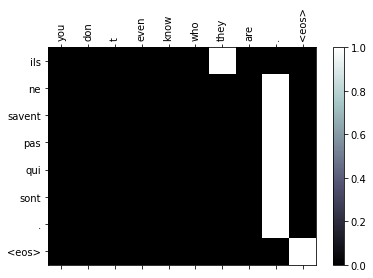

Actual Translation is vous ne savez meme pas qui ils sont .
------------------------------------------------
Decoder with Encoder Attention
souce:  you don t even know who they are .
prediction:  elles ne savent pas meme .


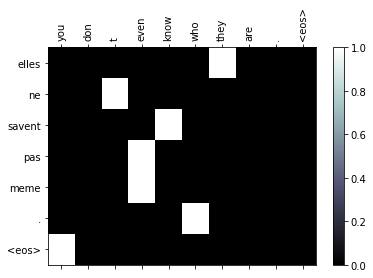

Actual Translation is vous ne savez meme pas qui ils sont .


In [58]:
print ("Third Example")
print ("Decoder with no Attention")

get_translation(nmt, source_list[2], source_lang_obj, use_cuda)

print ("Actual Translation is "+target_list[2])

print ("------------------------------------------------")

print ("Decoder with Encoder Attention")

get_translation(nmt_encoder_attn, source_list[2], source_lang_obj, use_cuda)

print ("Actual Translation is "+target_list[2])

print ("------------------------------------------------")

print ("Decoder with Encoder Attention")

get_translation(nmt_encoder_self_attn, source_list[2], source_lang_obj, use_cuda)

print ("Actual Translation is "+target_list[2])